In [1]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np

# from juices import Juices
# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
n = 2  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3], [2, 3, 1], [2, 3, 1]])

# 常数
K1 = 100
P = 30

# 量子比特数量
num_qubits = n * m + l

In [2]:
# 2. XY_mixer
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import QuantumCircuit, Aer, execute
from math import sqrt
from qiskit.visualization import plot_histogram
import math


def append_SCS_term(m, l, n):
    qc = QuantumCircuit(n, name='SCS_' + str(m) + ',' + str(l))
    m = m - 1
    for i in range(l):
        if (i + 1) == 1:
            qc.cx(m - 1, m)
            theta = sqrt(1 / (m + 1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(1)
            qc.append(c3ry_gate, [m, m - 1])
            qc.cx(m - 1, m)
        else:
            qc.cx(m - (i + 1), m)
            theta = sqrt((i + 1) / (m + 1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(2)
            qc.append(c3ry_gate, [m, m - (i + 1) + 1, m - (i + 1)])
            qc.cx(m - (i + 1), m)
    return qc


def get_Dicke_state_init_circuit(n, m, B, l):
    total_qubits = n * m + l
    qc = QuantumCircuit(total_qubits, name='modified_dicke_init')

    # 对前 n * m 个量子比特分组，每组 m 个量子比特中包含 B 个激发态
    for group in range(n):
        start = group * m  # 每组的起始索引
        for j in range(B):
            qc.x(start + j)  # 在每组的前 B 个比特上施加 X 门，使其为激发态

    # 在每组 m 个量子比特中应用 SCS 子电路生成激励共享态
    for group in range(n):
        start = group * m
        for i in range(m - 1):
            if m - i > B:
                qc.append(append_SCS_term(m - i, B, m), range(start, start + m))
            else:
                qc.append(append_SCS_term(m - i, m - i - 1, m), range(start, start + m))
            qc.barrier()

    # 额外的 l 个量子比特可用于纠缠初始化或其他操作
    for i in range(l):
        qc.h(n * m + i)

    return qc


In [3]:
# # n = 6 # 变量总数
# B = 1  # 限制1的个数
# # m = 2
# # k = 6
# qc = get_Dicke_state_init_circuit(n, m, B, l)
# dicke_circuit = QuantumCircuit(n*m+l, n*m+l)
# dicke_circuit.append(qc, range(n*m+l))
# dicke_circuit.measure(range(n*m+l), range(n*m+l))
# backend = Aer.get_backend('qasm_simulator')
# counts = execute(dicke_circuit, backend, shots = 10000).result().get_counts()
# print(counts)
# plot_histogram(counts)

In [4]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [5]:
def get_cost_circuit1(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for h in range(l):
        # print(m * n + h)
        coef = - 2 ** h
        append__z_term(qc, m * n + h, coef * gamma)
    return qc

In [6]:
def get_cost_circuit2(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(n):
        for j in range(m):
            append__z_term(qc, i * m + j, (2 - m) * K1 * gamma)
        # for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 != j2:
                    append__zz_term(qc, i * m + j1, i * m + j2, K1 * gamma)
    return qc

In [7]:
def get_cost_circuit3(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for j in range(m):
        for i in range(n):
            coef = -1 / 2 * (np.sum(p[:, j]) - (2 ** l - 1)) * P
            append__z_term(qc, i * m + j, 2 * coef * p[i, j] * gamma)
        for h in range(l):
            coef = -1 / 2 * (np.sum(p[:, j]) - (2 ** l - 1)) * P
            append__z_term(qc, m * n + h, -2 * (2 ** h) * coef * gamma)
        for i1 in range(n):
            for i2 in range(n):
                if i1 != i2:
                    coef = p[i1, j] * p[i2, j] * P
                    append__zz_term(qc, i1 * m + j, i2 * m + j, coef * gamma)
        for i in range(n):
            for h in range(l):
                coef = -1 * p[i, j] * 2 ** h * P
                append__zz_term(qc, i * m + j, m * n + h, coef * gamma)
        for h1 in range(l):
            for h2 in range(l):
                if h1 != h2:
                    coef = 2 ** h1 * 2 ** h2 * P
                    append__zz_term(qc, m * n + h1, m * n + h2, coef * gamma)
    return qc


In [8]:
def get_mixer_circuit(beta, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
        # qc.barrier()
    return qc

In [9]:
def get_mixer_circuit_xy(beta, qc):
    for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 < j2:
                    qc.rxx(2 * beta, i * m + j1, i * m + j2)
                    qc.ryy(2 * beta, i * m + j1, i * m + j2)

In [10]:
def invert_counts(s):
    return s[::-1]

In [11]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * m + l
    # qc = QuantumCircuit(num_qubits, num_qubits)  # 添加经典寄存器
    B = 1  # 限制1的个数
    dicke_circuit = get_Dicke_state_init_circuit(n, m, B, l)
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.append(dicke_circuit, range(num_qubits))
    # print(qc)

    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        # get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit_xy(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * m):]])
        x_ij = np.array([int(bit) for bit in bitstring[:(n * m)]]).reshape(n, m)

        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        E3 = 0
        for j in range(m):
            sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

            sum_zh = np.sum([2 ** h * z_h[h] for h in range(l)])

            max_value = max(0, sum_xp - sum_zh)

            E3 += P * (max_value) ** 2
        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts

In [12]:
from qiskit_algorithms.optimizers import COBYLA

# # 优化 QAOA 参数
# def optimize_qaoa(params):
#     def objective(params):
#         expectation, _ = cost_function(params)
# 
#         return expectation
# 
#     optimizer = COBYLA(rhobeg = 1.5, tol = 1e-7)
#     # params = np.random.rand(2 * p_max) * 2 * np.pi
#     result = optimizer.minimize(fun=objective, x0=params)
# 
#     return result
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params, optimizer):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    # optimizer = COBYLA(rhobeg = 1.5, tol = 1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    # 判断优化器类型：Qiskit 优化器 vs Scipy Optimizer
    if isinstance(optimizer, dict):  # 如果是Scipy的优化器
        result = minimize(
            fun=objective,
            x0=params,
            method=optimizer["method"],
            options=optimizer["options"]
        )
    else:  # 如果是Qiskit优化器
        result = optimizer.minimize(fun=objective, x0=params)
    # result = optimizer.minimize(fun=objective, x0=params)

    return result

In [16]:
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP
from scipy.optimize import minimize
from qiskit.algorithms.optimizers import SPSA

# 优化器配置
optimizers = [
    {
        # COBYLA(rhobeg = 1.5, tol = 1e-7)
        "name": "COBYLA",
        "func": lambda: COBYLA(rhobeg=1.5, tol=1e-7)
    },
    # {
    #     "name": "L-BFGS-B",
    #     "func": lambda: L_BFGS_B(tol=1e-6, maxfun=15000)
    # },
    # {
    #     "name": "SLSQP",
    #     "func": lambda: SLSQP(tol=1e-6)
    # },
    # {
    #     "name": "Powell",
    #     "func": lambda: {"method": "Powell", "options": {"xtol": 1e-6, "ftol": 1e-6, "maxiter": 1000, "disp": True}}
    # }

    # {
    #     "name": "Nelder-Mead",
    #     "func": lambda: Nelder-Mead(xatol = 1e-6)xatol': 1e-6, 'maxiter': 200}}
    # },
    # {
    #     "name": "PSO",
    #     "func": lambda: {"optimizer": "PSO", "swarmsize": 50, "maxiter": 100, "bounds": [0, 2 * 3.14]}
    # },
    # {
    #     "name": "Adam",
    #     "func": lambda: {"optimizer": "Adam", "learning_rate": 0.01}
    # }
]

Running optimizer: COBYLA
第： 1 层   第 0 个参数


C:\Users\李华宪\AppData\Local\Temp\ipykernel_67660\53416547.py:27: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 2 层   第 0 个参数
第： 2 层   第 1 个参数
第： 2 层   第 2 个参数
第： 2 层   第 3 个参数
第： 2 层   第 4 个参数
第： 2 层   第 5 个参数
第： 2 层   第 6 个参数
第： 2 层   第 7 个参数
第： 2 层   第 8 个参数
第： 2 层   第 9 个参数
第： 3 层   第 0 个参数
第： 3 层   第 1 个参数
第： 3 层   第 2 个参数
第： 3 层   第 3 个参数
第： 3 层   第 4 个参数
第： 3 层   第 5 个参数
第： 3 层   第 6 个参数
第： 3 层   第 7 个参数
第： 3 层   第 8 个参数
第： 3 层   第 9 个参数
优化时间： 97.87930035591125
Optimal parameters: [11.61470027  5.91300348  7.88802514  4.97917392  4.38255974  3.91269261]
Optimal value: 120.12109999999998
Final expectation value: 120.12109999999998
Final measurement counts: {'1000010': 2597, '1001001': 2153, '1000011': 1286, '0100010': 1034, '1001000': 645, '0101001': 573, '0010101': 447, '0101000': 258, '0010011': 237, '0100011': 223, '1000100': 192, '1000101': 117, '0010100': 88, '0010010': 68, '0011001': 35, '0011000': 31, '0100101': 10, '0100100': 6}

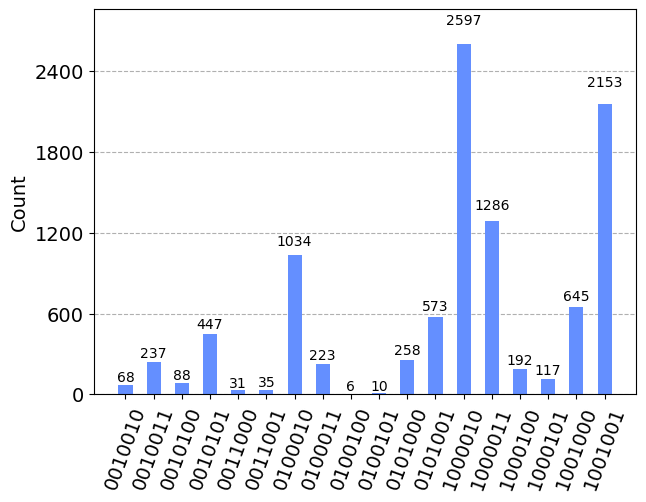

In [19]:
import time
from qiskit.visualization import plot_histogram

optimizer = optimizers[0]
# 运行优化
# for optimizer in optimizers:
print(f"Running optimizer: {optimizer['name']}")
# print(optimizer)
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(10):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, 2 * np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)

        result = optimize_qaoa(init_point_temp, optimizer['func']())

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [18]:
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [20]:
expectation = 0
bitstring = "1000011"
z_h = np.array([int(bit) for bit in bitstring[(n * m):]])
x_ij = np.array([int(bit) for bit in bitstring[:(n * m)]]).reshape(n, m)

E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
E3 = 0
e1 = 0
e2 = 0
for j in range(m):
    sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

    sum_zh = np.sum([2 ** h * z_h[h] for h in range(l)])

    max_value = max(0, sum_xp - sum_zh)
    e1 += sum_xp
    e2 += sum_zh
    E3 += P * (max_value) ** 2
E = E1 + E2 + E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

1
0
0
